# Import data and treat missing values

As observed in first iteration, the data is rather clean except some missing values

The fact that only 12 features included in the data means that we may skip the process of feature selection but we could consider feature engineering if needed

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from collections import Counter
from helper_func import *

In [2]:
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score,accuracy_score, confusion_matrix, roc_curve
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegressionCV

C:\Users\Zhiqing\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Zhiqing\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Zhiqing\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Zhiqing\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarnin

In [3]:
train_path = 'G:/Github/GiveMeSomeCredits/data/cs-training.csv'
test_path = 'G:/Github/GiveMeSomeCredits/data/cs-test.csv'

In [4]:
def data_import_and_preprocess(resample = 'ROS',scale = True):
    #import
    train_path = 'G:/Github/GiveMeSomeCredits/data/cs-training.csv'
    test_path = 'G:/Github/GiveMeSomeCredits/data/cs-test.csv'
    df_train = pd.read_csv(train_path,index_col = 0).reset_index()
    df_test = pd.read_csv(test_path,index_col = 0).reset_index()
    
    #fill in NA
    df_train = df_train.fillna(0)
    df_test = df_test.fillna(0)
    
    y = df_train.SeriousDlqin2yrs
    X = df_train.drop(columns=['SeriousDlqin2yrs','index'])
    X_test = df_test.drop(columns=['SeriousDlqin2yrs','index'])
    
    assert resample
    if resample == 'ROS':
        X_resampled, y_resampled = RandomOverSampler(random_state=0).fit_sample(X,y)
    elif resample == "SMOTE":
        X_resampled, y_resampled = SMOTE(random_state=0).fit_sample(X,y)
    
    if scale:
        scaler = preprocessing.StandardScaler().fit(X_resampled)
        X_train = scaler.transform(X_resampled)
        X_test = scaler.transform(X_test)
    else:
        X_train = X_resampled
    
    return X_train,y_resampled,X_test

In [13]:
df_test = pd.read_csv(test_path,index_col = 0).reset_index()

# Model training


* Light GBM model


In [5]:
X_train,y_train,X_test = data_import_and_preprocess()

In [8]:
import lightgbm
from sklearn.model_selection import GridSearchCV

In [9]:
clf = lightgbm.LGBMClassifier(num_leaves=80, 
                    max_depth=7, 
                    min_data_in_leaf=3,
                    objective='binary')

In [10]:
fitted_model,results = model_fit_train_score_skf(clf,X_train,y_train)

In [11]:
print(f"Accuracy: {results['Accuracy_mean']:.3f} \nF1 score: {results['F1_mean']:.3f} \nAUC score: {results['AUC_mean']:.3f}")

Accuracy: 0.814 
F1 score: 0.813 
AUC score: 0.898


In [14]:
df_test['Probability'] = fitted_model.predict_proba(X_test)[:,1]
columns_output = ['index','Probability']

output_df = pd.DataFrame(df_test[columns_output])
output_df = output_df.rename(columns={'index':"Id"})

save_path = 'G:/Github/GiveMeSomeCredits/output/1st_sublgbm.csv'
output_df.to_csv(save_path,index=False)

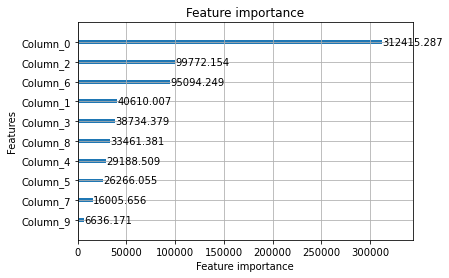

In [19]:
lightgbm.plot_importance(fitted_model,importance_type='gain')

* Kaggle score: 0.86194

Can we improve it?

In [33]:
param_test1 = {'num_leaves':[70,80,90,100,110],
              'max_depth':[7],
              'min_data_in_leaf':[1,3,5],
               'learning_rate':[0.001,0.01,0.05,0.1]
              }

gsearch1 = GridSearchCV(estimator=lightgbm.LGBMClassifier(objective='binary'),
                      param_grid=param_test1,
                       scoring='roc_auc',
                       n_jobs=-1, cv=5)

gsearch1.fit(X_train, y_train)
print(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)

{'mean_fit_time': array([4.46984544, 4.6122642 , 4.58475285, 4.57157779, 4.7022244 ,
       4.33919454, 4.30608263, 4.55182571, 4.55182543, 4.64258289,
       4.35235882, 4.411202  , 4.50995941, 4.90926909, 4.79278097,
       4.31067095, 4.21512547, 4.28813047, 4.35854192, 4.44491115,
       4.53467202, 4.60468392, 4.68048124, 4.77802062, 4.8277204 ,
       4.68147807, 4.76106601, 5.05049977, 5.19630151, 5.07183466,
       4.30548425, 4.38945951, 4.44570961, 4.12697673, 4.23987379,
       4.56877975, 4.26958022, 3.99930296, 4.02064624, 3.99272084,
       3.80842338, 3.80402541, 3.99531336, 4.09085879, 3.95601749,
       3.37059464, 3.46933084, 3.20402937, 3.32730098, 3.58361478,
       3.38355026, 3.32111692, 3.2744411 , 3.25349708, 3.3408639 ,
       3.25290036, 3.28321724, 3.39272437, 3.46333632, 3.31014628]), 'std_fit_time': array([0.06159452, 0.07058873, 0.02257621, 0.0502278 , 0.07348172,
       0.07043777, 0.03527016, 0.08854198, 0.02460005, 0.09874665,
       0.07228575, 0.04040

In [34]:
df_test['Probability'] = gsearch1.predict_proba(X_test)[:,1]
columns_output = ['index','Probability']

output_df = pd.DataFrame(df_test[columns_output])
output_df = output_df.rename(columns={'index':"Id"})

save_path = 'G:/Github/GiveMeSomeCredits/output/2nd_sublgbm.csv'
output_df.to_csv(save_path,index=False)

Kaggle private score > 0.85671

This suggests overfitting in the train set. We would want to deal with over fitting in light GBM by
 - limiting num_leaves
 - reduce max_depth > maybe 7 is too deep a tree for this problem, try 5 next
 - try to use bagging by set and bagging_freq
 
 (regularization methods more than above)